# 📓 Notebook - Teori & Praktik Bab 11: Training Deep Neural Networks

Bab ini membahas teknik-teknik lanjutan untuk melatih Deep Neural Networks agar proses pelatihan menjadi lebih cepat, stabil, dan mampu mencapai akurasi yang lebih tinggi. Masalah utama yang dihadapi pada jaringan dalam (*deep nets*) meliputi hilangnya gradien (*vanishing gradients*), lambatnya pelatihan, dan risiko *overfitting*.

Topik pembahasan meliputi:
1.  **Vanishing & Exploding Gradients** (Inisialisasi & Aktivasi)
2.  **Batch Normalization**
3.  **Gradient Clipping**
4.  **Transfer Learning**
5.  **Faster Optimizers** (Momentum, Adam, Nadam)
6.  **Learning Rate Scheduling**
7.  **Regularization** (L1/L2, Dropout)

In [14]:
# Setup Awal
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
# Pastikan hasil dapat direproduksi
tf.random.set_seed(42)
np.random.seed(42)

# Dataset Fashion MNIST digunakan sebagai contoh data uji
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

## 1. Vanishing & Exploding Gradients

### Teori
Salah satu masalah utama dalam melatih jaringan yang sangat dalam adalah gradien yang menjadi sangat kecil (*vanishing*) atau sangat besar (*exploding*) saat merambat mundur (*backpropagation*) dari output layer ke input layer. Hal ini menyebabkan bobot pada lapisan awal sulit diperbarui.

Solusi yang diterapkan:
1.  **Inisialisasi Bobot yang Tepat:** Menggunakan inisialisasi *He Initialization* untuk fungsi aktivasi ReLU/ELU, atau *Glorot (Xavier) Initialization* untuk Sigmoid/Tanh/Logistic.
2.  **Fungsi Aktivasi Non-Saturating:** Menghindari Sigmoid. Disarankan menggunakan **ELU (Exponential Linear Unit)** atau **SELU (Scaled ELU)** untuk jaringan dalam, atau **ReLU** dan variannya (Leaky ReLU) untuk kecepatan.

In [15]:
# Implementasi He Initialization dan Aktivasi ELU
model = keras.models.Sequential([
    # PERUBAHAN 1: Gunakan Input Layer secara eksplisit
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Flatten(),
    
    # HeNormal sangat cocok dipasangkan dengan ELU atau ReLU
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax")
])

# Leaky ReLU sebagai alternatif
model_leaky = keras.models.Sequential([
    # PERUBAHAN 1: Gunakan Input Layer secara eksplisit
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Flatten(),
    
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    # PERUBAHAN 2: Ganti 'alpha' menjadi 'negative_slope'
    keras.layers.LeakyReLU(negative_slope=0.2), 
    keras.layers.Dense(10, activation="softmax")
])

print("Konfigurasi layer pertama:", model.layers[1].get_config()['activation'])

Konfigurasi layer pertama: elu


In [16]:
# Fungsi untuk membuat model dengan aktivasi berbeda
def build_model(activation="elu", name="model"):
    model = keras.models.Sequential([
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(300, kernel_initializer="he_normal"),
    ])
    
    if activation == "leaky_relu":
        model.add(keras.layers.LeakyReLU(negative_slope=0.2))
    else:
        model.add(keras.layers.Activation(activation))
    
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    
    if activation == "leaky_relu":
        model.add(keras.layers.LeakyReLU(negative_slope=0.2))
    else:
        model.add(keras.layers.Activation(activation))
    
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="nadam",
                  metrics=["accuracy"])
    return model

# Membuat dan melatih 3 model dengan aktivasi berbeda
print("🔄 Melatih model dengan ELU...")
model_elu = build_model("elu", "ELU")
history_elu = model_elu.fit(X_train, y_train, epochs=20, 
                            validation_data=(X_valid, y_valid),
                            verbose=0)

print("🔄 Melatih model dengan ReLU...")
model_relu = build_model("relu", "ReLU")
history_relu = model_relu.fit(X_train, y_train, epochs=20, 
                              validation_data=(X_valid, y_valid),
                              verbose=0)

print("🔄 Melatih model dengan Leaky ReLU...")
model_leaky_relu = build_model("leaky_relu", "Leaky ReLU")
history_leaky_relu = model_leaky_relu.fit(X_train, y_train, epochs=20, 
                                          validation_data=(X_valid, y_valid),
                                          verbose=0)

print("✅ Selesai!")

# Evaluasi pada test set
test_loss_elu, test_acc_elu = model_elu.evaluate(X_test, y_test, verbose=0)
test_loss_relu, test_acc_relu = model_relu.evaluate(X_test, y_test, verbose=0)
test_loss_leaky, test_acc_leaky = model_leaky_relu.evaluate(X_test, y_test, verbose=0)

print(f"\n📊 Test Accuracy:")
print(f"   ELU:        {test_acc_elu:.4f}")
print(f"   ReLU:       {test_acc_relu:.4f}")
print(f"   Leaky ReLU: {test_acc_leaky:.4f}")

🔄 Melatih model dengan ELU...
🔄 Melatih model dengan ReLU...
🔄 Melatih model dengan Leaky ReLU...
✅ Selesai!

📊 Test Accuracy:
   ELU:        0.8776
   ReLU:       0.8826
   Leaky ReLU: 0.8689


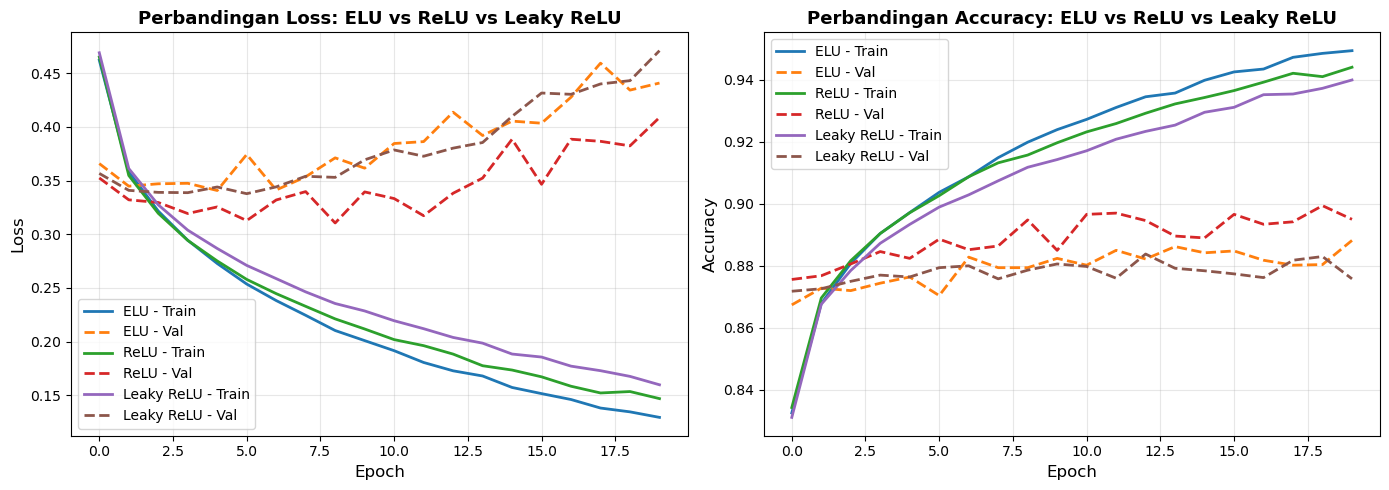

💡 Insight: ELU biasanya memberikan hasil sedikit lebih baik karena memiliki output negatif
   yang membantu mengatasi vanishing gradient, namun ReLU lebih cepat dalam komputasi.


In [17]:
# Visualisasi perbandingan fungsi aktivasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axes[0].plot(history_elu.history['loss'], label='ELU - Train', linewidth=2)
axes[0].plot(history_elu.history['val_loss'], label='ELU - Val', linewidth=2, linestyle='--')
axes[0].plot(history_relu.history['loss'], label='ReLU - Train', linewidth=2)
axes[0].plot(history_relu.history['val_loss'], label='ReLU - Val', linewidth=2, linestyle='--')
axes[0].plot(history_leaky_relu.history['loss'], label='Leaky ReLU - Train', linewidth=2)
axes[0].plot(history_leaky_relu.history['val_loss'], label='Leaky ReLU - Val', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Perbandingan Loss: ELU vs ReLU vs Leaky ReLU', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(history_elu.history['accuracy'], label='ELU - Train', linewidth=2)
axes[1].plot(history_elu.history['val_accuracy'], label='ELU - Val', linewidth=2, linestyle='--')
axes[1].plot(history_relu.history['accuracy'], label='ReLU - Train', linewidth=2)
axes[1].plot(history_relu.history['val_accuracy'], label='ReLU - Val', linewidth=2, linestyle='--')
axes[1].plot(history_leaky_relu.history['accuracy'], label='Leaky ReLU - Train', linewidth=2)
axes[1].plot(history_leaky_relu.history['val_accuracy'], label='Leaky ReLU - Val', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Perbandingan Accuracy: ELU vs ReLU vs Leaky ReLU', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Insight: ELU biasanya memberikan hasil sedikit lebih baik karena memiliki output negatif")
print("   yang membantu mengatasi vanishing gradient, namun ReLU lebih cepat dalam komputasi.")

## 2. Batch Normalization

### Teori
Meskipun inisialisasi He membantu di awal, distribusi input tiap layer dapat berubah selama pelatihan (*Internal Covariate Shift*). **Batch Normalization (BN)** mengatasi ini dengan menstandarisasi input (mean=0, variance=1) di setiap layer, lalu menskalakan dan menggesernya.

Posisi BN biasanya ditempatkan **setelah** fungsi aktivasi (menurut paper asli) atau **sebelum** fungsi aktivasi (praktik umum saat ini). Implementasi di bawah meletakkan BN setelah aktivasi layer.

In [18]:
# Implementasi Batch Normalization
model_bn = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(), # Menstandarisasi output dari dense layer
    keras.layers.Activation("elu"),   # Aktivasi dilakukan setelah normalisasi
    
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    
    keras.layers.Dense(10, activation="softmax")
])

model_bn.summary()
# Catatan: Parameter BN (gamma, beta, moving_mean, moving_variance) menambah jumlah parameter non-trainable.

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_16 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 300)            │       235,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 100)            │        30,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,810 (1.02 MB)

 Trainable params: 267,010 (1.02 MB)

 Non-trainable params: 800 (3.12 KB)

In [19]:
# Model TANPA Batch Normalization
model_no_bn = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax")
])

# Model DENGAN Batch Normalization
model_with_bn = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

# Compile kedua model
model_no_bn.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model_with_bn.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Training
print("🔄 Melatih model TANPA Batch Normalization...")
history_no_bn = model_no_bn.fit(X_train, y_train, epochs=20, 
                                validation_data=(X_valid, y_valid), 
                                verbose=0)

print("🔄 Melatih model DENGAN Batch Normalization...")
history_with_bn = model_with_bn.fit(X_train, y_train, epochs=20, 
                                    validation_data=(X_valid, y_valid), 
                                    verbose=0)

print("✅ Selesai!")

# Evaluasi
test_loss_no_bn, test_acc_no_bn = model_no_bn.evaluate(X_test, y_test, verbose=0)
test_loss_with_bn, test_acc_with_bn = model_with_bn.evaluate(X_test, y_test, verbose=0)

print(f"\n📊 Test Accuracy:")
print(f"   Tanpa BN: {test_acc_no_bn:.4f}")
print(f"   Dengan BN: {test_acc_with_bn:.4f}")
print(f"   Peningkatan: {(test_acc_with_bn - test_acc_no_bn)*100:.2f}%")

🔄 Melatih model TANPA Batch Normalization...
🔄 Melatih model DENGAN Batch Normalization...
✅ Selesai!

📊 Test Accuracy:
   Tanpa BN: 0.8828
   Dengan BN: 0.8550
   Peningkatan: -2.78%


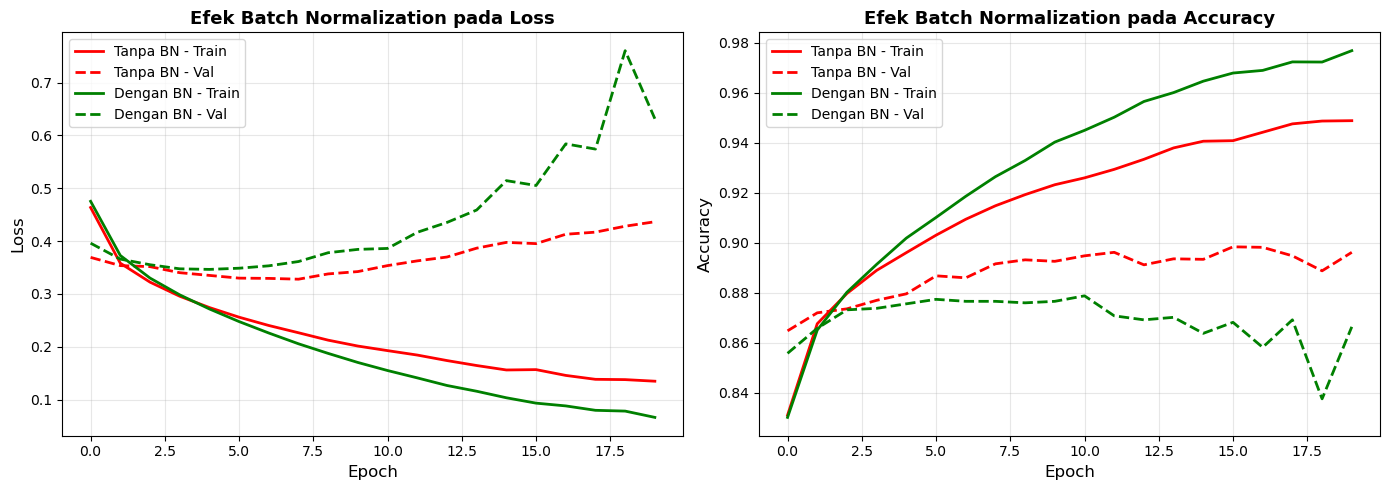

💡 Insight: Batch Normalization mempercepat konvergensi dan membuat training lebih stabil.
   Perhatikan kurva yang lebih smooth dan konvergensi yang lebih cepat pada model dengan BN.


In [20]:
# Visualisasi perbandingan Batch Normalization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axes[0].plot(history_no_bn.history['loss'], label='Tanpa BN - Train', linewidth=2, color='red')
axes[0].plot(history_no_bn.history['val_loss'], label='Tanpa BN - Val', linewidth=2, linestyle='--', color='red')
axes[0].plot(history_with_bn.history['loss'], label='Dengan BN - Train', linewidth=2, color='green')
axes[0].plot(history_with_bn.history['val_loss'], label='Dengan BN - Val', linewidth=2, linestyle='--', color='green')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Efek Batch Normalization pada Loss', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(history_no_bn.history['accuracy'], label='Tanpa BN - Train', linewidth=2, color='red')
axes[1].plot(history_no_bn.history['val_accuracy'], label='Tanpa BN - Val', linewidth=2, linestyle='--', color='red')
axes[1].plot(history_with_bn.history['accuracy'], label='Dengan BN - Train', linewidth=2, color='green')
axes[1].plot(history_with_bn.history['val_accuracy'], label='Dengan BN - Val', linewidth=2, linestyle='--', color='green')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Efek Batch Normalization pada Accuracy', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Insight: Batch Normalization mempercepat konvergensi dan membuat training lebih stabil.")
print("   Perhatikan kurva yang lebih smooth dan konvergensi yang lebih cepat pada model dengan BN.")

## 3. Gradient Clipping

### Teori
Untuk menghindari masalah *Exploding Gradients* (terutama pada Recurrent Neural Networks), teknik **Gradient Clipping** membatasi nilai gradien agar tidak melebihi ambang batas tertentu selama *backpropagation*. Konfigurasi ini dilakukan pada optimizer.

In [21]:
# clipvalue: Memotong nilai gradien di antara -1.0 dan 1.0
optimizer_clip = keras.optimizers.SGD(learning_rate=0.01, clipvalue=1.0)

# clipnorm: Memotong vektor gradien agar norm-nya (panjang vektor) maks 1.0 (mempertahankan arah vektor)
optimizer_norm = keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.0)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_clip, metrics=["accuracy"])

## 4. Transfer Learning

### Teori
Transfer Learning adalah teknik menggunakan kembali layer dari model yang sudah dilatih (*pretrained model*) untuk tugas baru yang mirip. Ini mempercepat pelatihan secara drastis.

Langkah-langkah:
1.  Muat model A (pretrained).
2.  Gunakan kembali layer-layer awal model A (kecuali output layer).
3.  Bekukan (*freeze*) layer tersebut agar bobotnya tidak rusak saat awal pelatihan model baru.
4.  Latih model baru (Model B) dengan output layer baru.

In [22]:
# Simulasi: Anggap model_bn adalah Model A yang sudah dilatih
model_A = model_bn
model_A.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
model_A.fit(X_train[:1000], y_train[:1000], epochs=1, verbose=0) # Simulasi training sebentar

# Membuat Model B berdasarkan layer Model A (kecuali layer output terakhir)
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(10, activation="softmax")) # Layer output baru

# Membekukan layer lama (Freezing)
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

# Compile model B
model_B_on_A.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

print("Status trainable layer pertama:", model_B_on_A.layers[0].trainable)
# Setelah beberapa epoch, layer bisa di-unfreeze untuk fine-tuning

Status trainable layer pertama: False


## 5. Faster Optimizers

### Teori
Stochastic Gradient Descent (SGD) standar seringkali lambat. Optimizer modern mempercepat konvergensi dengan melacak momentum atau menyesuaikan learning rate secara adaptif.

Pilihan populer:
1.  **Momentum Optimization:** Mempercepat SGD dengan menambahkan vektor momentum (seperti bola menggelinding).
2.  **RMSProp:** Menyesuaikan learning rate untuk setiap parameter, mencegah osilasi.
3.  **Adam (Adaptive Moment Estimation):** Menggabungkan Momentum dan RMSProp. Sering menjadi pilihan *default* terbaik.
4.  **Nadam:** Varian Adam dengan Nesterov Momentum (seringkali sedikit lebih baik dari Adam).

In [23]:
# Implementasi berbagai optimizer

# 1. Momentum
opt_momentum = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

# 2. RMSProp
opt_rmsprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

# 3. Adam
opt_adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# 4. Nadam
opt_nadam = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Penggunaan dalam compile
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt_nadam, metrics=["accuracy"])

In [24]:
# Fungsi untuk membuat model yang sama
def create_model():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
        keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
        keras.layers.Dense(10, activation="softmax")
    ])
    return model

# Dictionary untuk menyimpan optimizer dan history
optimizers = {
    'SGD': keras.optimizers.SGD(learning_rate=0.01),
    'Momentum': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'Adam': keras.optimizers.Adam(learning_rate=0.001),
    'Nadam': keras.optimizers.Nadam(learning_rate=0.001)
}

histories = {}
test_accuracies = {}

# Melatih model dengan setiap optimizer
for name, optimizer in optimizers.items():
    print(f"🔄 Melatih model dengan {name}...")
    model = create_model()
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer, 
                  metrics=["accuracy"])
    
    history = model.fit(X_train, y_train, epochs=20, 
                       validation_data=(X_valid, y_valid), 
                       verbose=0)
    
    histories[name] = history
    
    # Evaluasi
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    test_accuracies[name] = test_acc

print("\n✅ Selesai!")
print(f"\n📊 Test Accuracy:")
for name, acc in test_accuracies.items():
    print(f"   {name:10s}: {acc:.4f}")

🔄 Melatih model dengan SGD...
🔄 Melatih model dengan Momentum...
🔄 Melatih model dengan RMSprop...
🔄 Melatih model dengan Adam...
🔄 Melatih model dengan Nadam...

✅ Selesai!

📊 Test Accuracy:
   SGD       : 0.8711
   Momentum  : 0.8723
   RMSprop   : 0.8517
   Adam      : 0.8738
   Nadam     : 0.8806


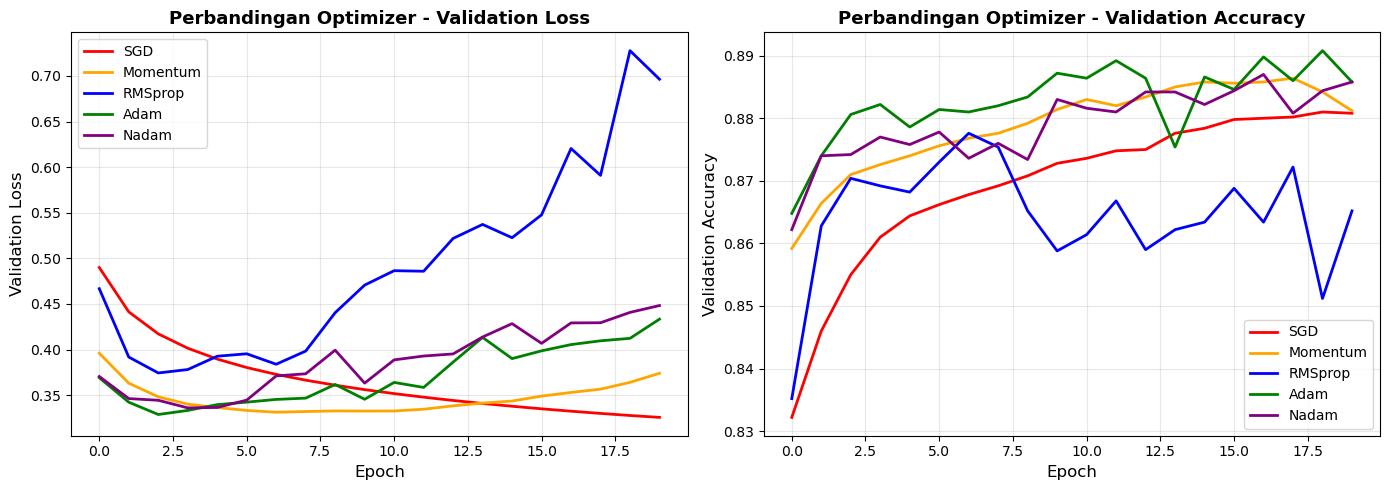

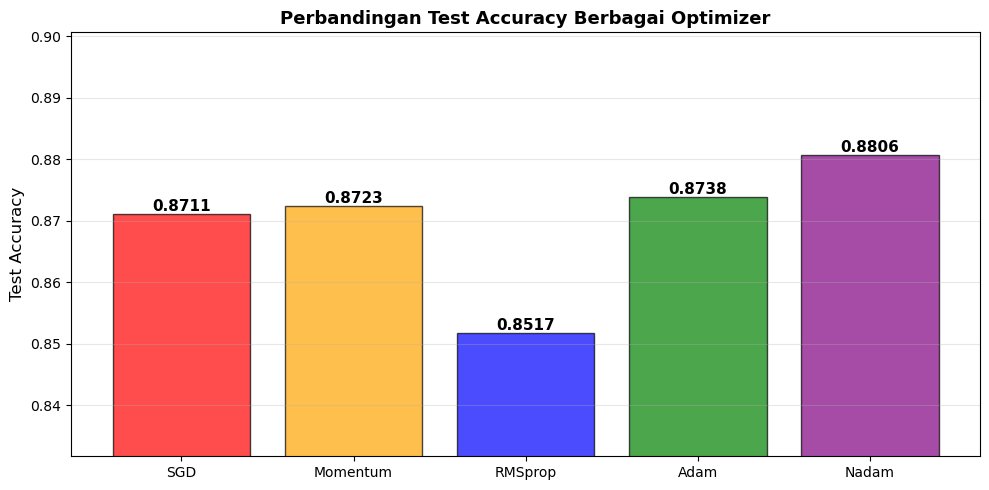

💡 Insight: Adam dan Nadam biasanya memberikan hasil terbaik dengan konvergensi tercepat.
   SGD standar paling lambat, sementara Momentum mempercepat konvergensi SGD secara signifikan.


In [25]:
# Visualisasi perbandingan optimizer
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['red', 'orange', 'blue', 'green', 'purple']

# Plot Loss
for (name, history), color in zip(histories.items(), colors):
    axes[0].plot(history.history['val_loss'], label=name, linewidth=2, color=color)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Validation Loss', fontsize=12)
axes[0].set_title('Perbandingan Optimizer - Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
for (name, history), color in zip(histories.items(), colors):
    axes[1].plot(history.history['val_accuracy'], label=name, linewidth=2, color=color)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Accuracy', fontsize=12)
axes[1].set_title('Perbandingan Optimizer - Validation Accuracy', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Bar chart test accuracy
fig, ax = plt.subplots(figsize=(10, 5))
names = list(test_accuracies.keys())
accs = list(test_accuracies.values())
bars = ax.bar(names, accs, color=colors, alpha=0.7, edgecolor='black')

# Tambahkan nilai di atas bar
for bar, acc in zip(bars, accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Perbandingan Test Accuracy Berbagai Optimizer', fontsize=13, fontweight='bold')
ax.set_ylim([min(accs) - 0.02, max(accs) + 0.02])
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 Insight: Adam dan Nadam biasanya memberikan hasil terbaik dengan konvergensi tercepat.")
print("   SGD standar paling lambat, sementara Momentum mempercepat konvergensi SGD secara signifikan.")

## 6. Learning Rate Scheduling

### Teori
Menemukan learning rate yang pas itu sulit. Strategi yang efektif adalah memulai dengan nilai besar, lalu menurunkannya seiring proses pelatihan (*Decay*).

Metode `ReduceLROnPlateau` sangat berguna: ia mengurangi learning rate secara dinamis jika *validation loss* berhenti menurun.

In [26]:
# Callback untuk mengurangi LR jika val_loss stagnan selama 5 epoch
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# Implementasi dalam training
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler], 
                    verbose=0) # verbose=0 agar output tidak memenuhi layar notebook

# Memeriksa learning rate terakhir
print("Learning Rate akhir:", model.optimizer.learning_rate.numpy())

Learning Rate akhir: 0.0005


In [27]:
# Custom callback untuk tracking learning rate
class LRHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.lr_history = []
    
    def on_epoch_end(self, epoch, logs={}):
        # Mendapatkan learning rate saat ini
        lr = float(self.model.optimizer.learning_rate.numpy())
        self.lr_history.append(lr)

# Model dengan LR Scheduling
model_lr_schedule = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model_lr_schedule.compile(loss="sparse_categorical_crossentropy",
                          optimizer=keras.optimizers.Adam(learning_rate=0.01),  # Start dengan LR tinggi
                          metrics=["accuracy"])

# Callbacks
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1, min_lr=1e-7)
lr_history_callback = LRHistory()

print("🔄 Melatih model dengan Learning Rate Scheduling...")
history_lr = model_lr_schedule.fit(X_train, y_train, epochs=30, 
                                   validation_data=(X_valid, y_valid),
                                   callbacks=[lr_scheduler, lr_history_callback],
                                   verbose=0)

print("✅ Selesai!")

# Evaluasi
test_loss_lr, test_acc_lr = model_lr_schedule.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 Test Accuracy dengan LR Scheduling: {test_acc_lr:.4f}")

🔄 Melatih model dengan Learning Rate Scheduling...

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
✅ Selesai!

📊 Test Accuracy dengan LR Scheduling: 0.8826


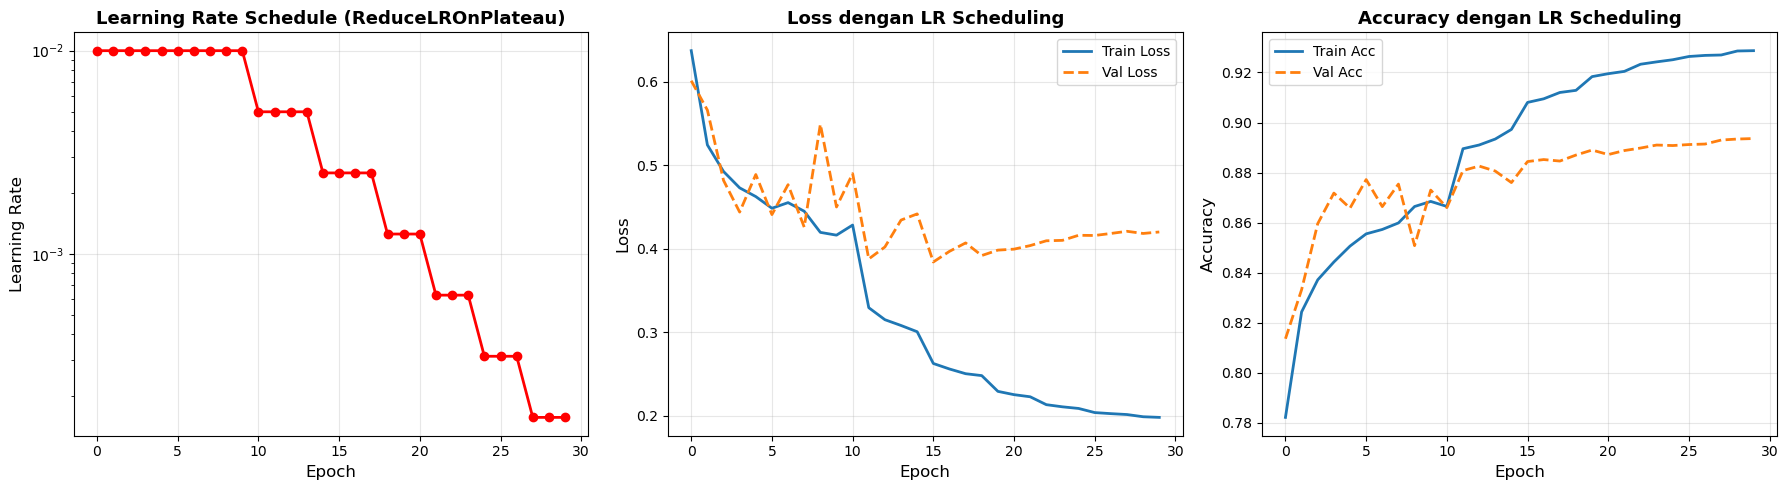

💡 Insight: Perhatikan bagaimana Learning Rate turun bertahap saat val_loss berhenti membaik.
   Ini membantu model melakukan fine-tuning untuk mencapai hasil optimal.


In [28]:
# Visualisasi Learning Rate Schedule dan dampaknya
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Learning Rate over epochs
axes[0].plot(lr_history_callback.lr_history, linewidth=2, color='red', marker='o')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Learning Rate', fontsize=12)
axes[0].set_title('Learning Rate Schedule (ReduceLROnPlateau)', fontsize=13, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss
axes[1].plot(history_lr.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_lr.history['val_loss'], label='Val Loss', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss dengan LR Scheduling', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Accuracy
axes[2].plot(history_lr.history['accuracy'], label='Train Acc', linewidth=2)
axes[2].plot(history_lr.history['val_accuracy'], label='Val Acc', linewidth=2, linestyle='--')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Accuracy', fontsize=12)
axes[2].set_title('Accuracy dengan LR Scheduling', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Insight: Perhatikan bagaimana Learning Rate turun bertahap saat val_loss berhenti membaik.")
print("   Ini membantu model melakukan fine-tuning untuk mencapai hasil optimal.")

## 7. Regularization (Menghindari Overfitting)

### Teori
Deep Neural Networks dengan jutaan parameter sangat rentan terhadap *overfitting*. Teknik regularisasi membatasi fleksibilitas model.

1.  **L1 & L2 Regularization:** Menambahkan penalti pada loss function berdasarkan besarnya bobot.
2.  **Dropout:** Secara acak menonaktifkan neuron (misal 50%) di setiap langkah pelatihan. Ini memaksa jaringan untuk tidak bergantung pada satu neuron tertentu.
3.  **Alpha Dropout:** Varian dropout yang menjaga mean dan variance tetap stabil, cocok digunakan bersamaan dengan SELU.

In [29]:
# Implementasi L2 Regularization dan Dropout
model_reg = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    
    # Dense layer dengan L2 Regularization (factor 0.01)
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    
    # Dropout Layer (rate 0.5 artinya 50% neuron dimatikan acak saat training)
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(10, activation="softmax")
])

model_reg.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
# Saat evaluasi/prediksi, layer Dropout otomatis tidak aktif.

In [30]:
# Model 1: TANPA Regularisasi (Prone to Overfitting)
model_no_reg = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax")
])

# Model 2: DENGAN Dropout
model_dropout = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(10, activation="softmax")
])

# Model 3: DENGAN L2 Regularization
model_l2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu", 
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu", 
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax")
])

# Model 4: DENGAN Dropout + L2 (Kombinasi)
model_combined = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu", 
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.005)),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(100, activation="elu", 
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.005)),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(10, activation="softmax")
])

# Compile semua model
models_reg = {
    'Tanpa Regularisasi': model_no_reg,
    'Dengan Dropout': model_dropout,
    'Dengan L2': model_l2,
    'Dropout + L2': model_combined
}

for name, model in models_reg.items():
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="nadam",
                  metrics=["accuracy"])

# Training
histories_reg = {}
test_accs_reg = {}

for name, model in models_reg.items():
    print(f"🔄 Melatih model: {name}...")
    history = model.fit(X_train, y_train, epochs=30, 
                       validation_data=(X_valid, y_valid),
                       verbose=0)
    histories_reg[name] = history
    
    # Evaluasi
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    test_accs_reg[name] = test_acc

print("\n✅ Selesai!")
print(f"\n📊 Test Accuracy:")
for name, acc in test_accs_reg.items():
    print(f"   {name:25s}: {acc:.4f}")

🔄 Melatih model: Tanpa Regularisasi...
🔄 Melatih model: Dengan Dropout...
🔄 Melatih model: Dengan L2...
🔄 Melatih model: Dropout + L2...

✅ Selesai!

📊 Test Accuracy:
   Tanpa Regularisasi       : 0.8772
   Dengan Dropout           : 0.8786
   Dengan L2                : 0.8254
   Dropout + L2             : 0.8070


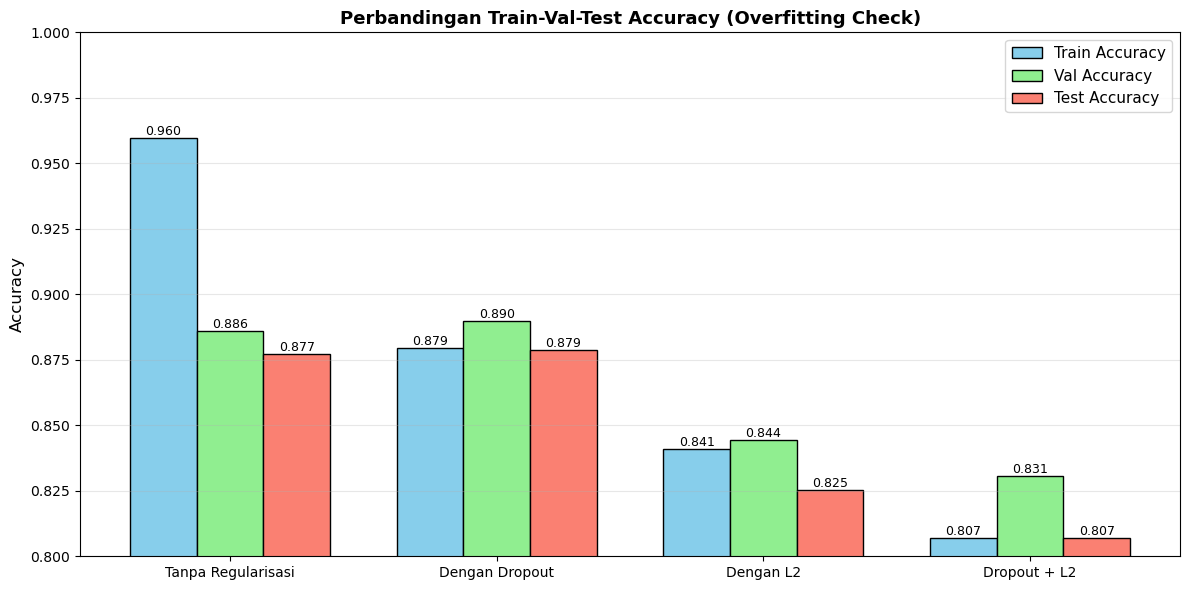

💡 Insight: Model terbaik adalah yang memiliki gap terkecil antara Train-Val-Test Accuracy.
   Model dengan regularisasi cenderung lebih general dan performa test-nya lebih baik.


In [37]:
# Perbandingan overfitting: Train-Val accuracy gap
fig, ax = plt.subplots(figsize=(12, 6))

names_reg = list(histories_reg.keys())
train_accs = [histories_reg[name].history['accuracy'][-1] for name in names_reg]
val_accs = [histories_reg[name].history['val_accuracy'][-1] for name in names_reg]
test_accs_list = [test_accs_reg[name] for name in names_reg]

x = np.arange(len(names_reg))
width = 0.25

bars1 = ax.bar(x - width, train_accs, width, label='Train Accuracy', color='skyblue', edgecolor='black')
bars2 = ax.bar(x, val_accs, width, label='Val Accuracy', color='lightgreen', edgecolor='black')
bars3 = ax.bar(x + width, test_accs_list, width, label='Test Accuracy', color='salmon', edgecolor='black')

# Tambahkan nilai di atas bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Perbandingan Train-Val-Test Accuracy (Overfitting Check)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(names_reg, fontsize=10)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)
ax.set_ylim([0.8, 1.0])

plt.tight_layout()
plt.show()

print("💡 Insight: Model terbaik adalah yang memiliki gap terkecil antara Train-Val-Test Accuracy.")
print("   Model dengan regularisasi cenderung lebih general dan performa test-nya lebih baik.")

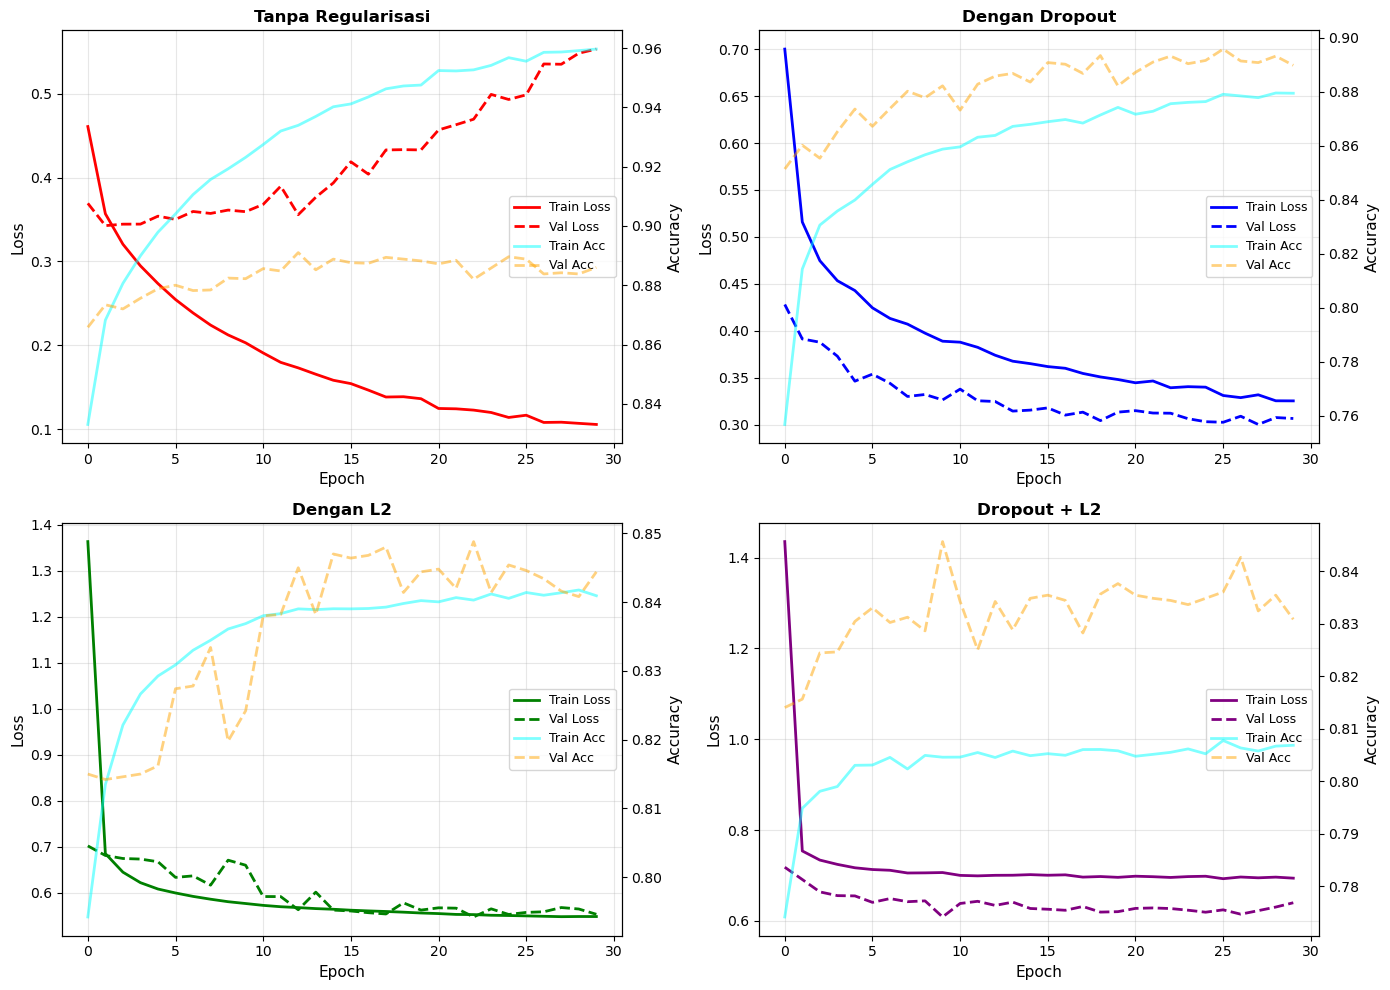

💡 Insight: Perhatikan gap antara training dan validation curves.
   - Model tanpa regularisasi menunjukkan overfitting (gap besar)
   - Dropout dan L2 mengurangi gap ini dengan mencegah model terlalu 'menghafal' data training


In [38]:
# Visualisasi efek regularisasi
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors_reg = ['red', 'blue', 'green', 'purple']

# Plot untuk setiap model
for idx, (name, history) in enumerate(histories_reg.items()):
    row = idx // 2
    col = idx % 2
    
    ax = axes[row, col]
    
    # Plot training dan validation loss
    ax.plot(history.history['loss'], label='Train Loss', linewidth=2, color=colors_reg[idx])
    ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2, 
            linestyle='--', color=colors_reg[idx])
    
    # Plot training dan validation accuracy (sumbu kanan)
    ax2 = ax.twinx()
    ax2.plot(history.history['accuracy'], label='Train Acc', linewidth=2, 
             alpha=0.5, color='cyan')
    ax2.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2, 
             linestyle='--', alpha=0.5, color='orange')
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11)
    ax2.set_ylabel('Accuracy', fontsize=11)
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    
    # Gabungkan legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=9)
    
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Insight: Perhatikan gap antara training dan validation curves.")
print("   - Model tanpa regularisasi menunjukkan overfitting (gap besar)")
print("   - Dropout dan L2 mengurangi gap ini dengan mencegah model terlalu 'menghafal' data training")

### Kesimpulan Bab 11

Untuk membangun jaringan saraf dalam (*deep neural network*) yang berkinerja tinggi, konfigurasi yang disarankan secara umum adalah:
* **Inisialisasi:** He Initialization.
* **Aktivasi:** ELU (atau ReLU untuk kecepatan).
* **Normalisasi:** Batch Normalization (untuk jaringan yang sangat dalam).
* **Regularisasi:** Dropout dan/atau L2.
* **Optimizer:** Adam atau Nadam.
* **Learning Rate:** Gunakan Scheduling (misal `ReduceLROnPlateau`).

### 📊 Ringkasan Semua Eksperimen

## Evaluasi Final: Model Terbaik

Berdasarkan semua eksperimen di atas, mari kita buat model final dengan konfigurasi terbaik dan evaluasi secara menyeluruh.

In [ ]:
model_final = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dropout(rate=0.3),
    
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dropout(rate=0.3),
    
    keras.layers.Dense(10, activation="softmax")
])

model_final.compile(loss="sparse_categorical_crossentropy",
                    optimizer=keras.optimizers.Nadam(learning_rate=0.001),
                    metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler_final = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

print("🔄 Melatih model final dengan konfigurasi terbaik...")
history_final = model_final.fit(X_train, y_train, epochs=50, 
                                validation_data=(X_valid, y_valid),
                                callbacks=[early_stopping, lr_scheduler_final],
                                verbose=1)

print("\n✅ Training selesai!")

test_loss_final, test_acc_final = model_final.evaluate(X_test, y_test)
print(f"\n🎯 Final Test Accuracy: {test_acc_final:.4f}")

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔄 Melatih model final dengan konfigurasi terbaik...
Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8035 - loss: 0.5631 - val_accuracy: 0.8432 - val_loss: 0.4216 - learning_rate: 0.0010
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8357 - loss: 0.4536 - val_accuracy: 0.8550 - val_loss: 0.3968 - learning_rate: 0.0010
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8486 - loss: 0.4196 - val_accuracy: 0.8560 - val_loss: 0.3802 - learning_rate: 0.0010
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8555 - loss: 0.3966 - val_accuracy: 0.8652 - val_loss: 0.3645 - learning_rate: 0.0010
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8635 - loss: 0.3779 - val_accuracy: 0.8736 - val_loss: 0.3416 - learning_rate: 0.0010
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8682 - loss: 0.3638 - val_accuracy: 0.8746 - val_loss: 0.3465 - learning_rate: 0.0010
Epoch 7/50
1719/1719 ━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


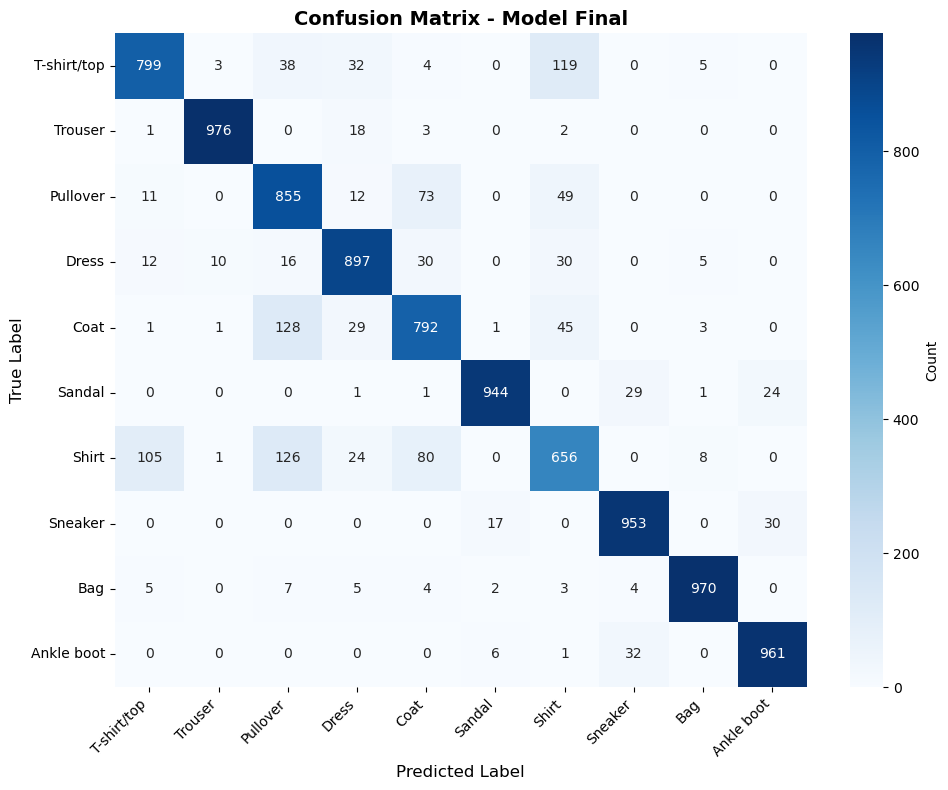


📊 Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.80      0.83      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.73      0.85      0.79      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.80      0.79      0.80      1000
      Sandal       0.97      0.94      0.96      1000
       Shirt       0.72      0.66      0.69      1000
     Sneaker       0.94      0.95      0.94      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model_final.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Model Final', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n📊 Classification Report:")
print("="*70)
print(classification_report(y_test, y_pred_classes, target_names=class_names))

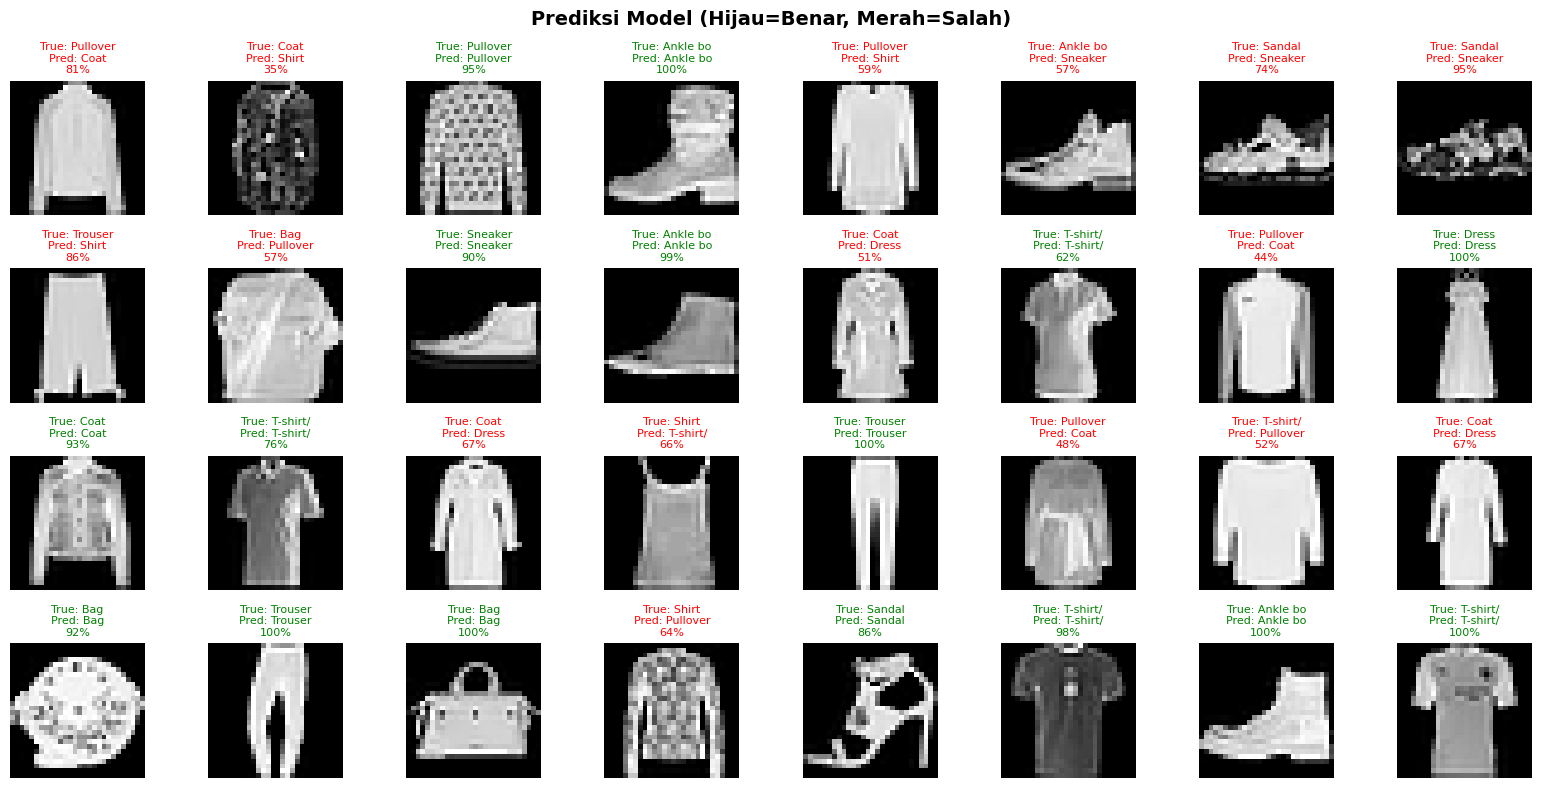

💡 Perhatikan gambar dengan warna merah - ini adalah prediksi yang salah.
   Analisis error ini membantu memahami kasus sulit untuk model.


In [ ]:
n_rows, n_cols = 4, 8
plt.figure(figsize=(16, 8))

correct_indices = np.where(y_pred_classes == y_test)[0]
incorrect_indices = np.where(y_pred_classes != y_test)[0]

sample_correct = np.random.choice(correct_indices, n_rows * n_cols // 2, replace=False)
sample_incorrect = np.random.choice(incorrect_indices, n_rows * n_cols // 2, replace=False)
samples = np.concatenate([sample_correct, sample_incorrect])
np.random.shuffle(samples)

for i, idx in enumerate(samples):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(X_test[idx], cmap='gray')
    
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred_classes[idx]]
    confidence = np.max(y_pred[idx]) * 100
    
    # Warna hijau jika benar, merah jika salah
    color = 'green' if y_test[idx] == y_pred_classes[idx] else 'red'
    
    plt.title(f'True: {true_label[:8]}\nPred: {pred_label[:8]}\n{confidence:.0f}%', 
              fontsize=8, color=color)
    plt.axis('off')

plt.suptitle('Prediksi Model (Hijau=Benar, Merah=Salah)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 Perhatikan gambar dengan warna merah - ini adalah prediksi yang salah.")
print("   Analisis error ini membantu memahami kasus sulit untuk model.")

### Visualisasi Prediksi Model

### Confusion Matrix dan Classification Report

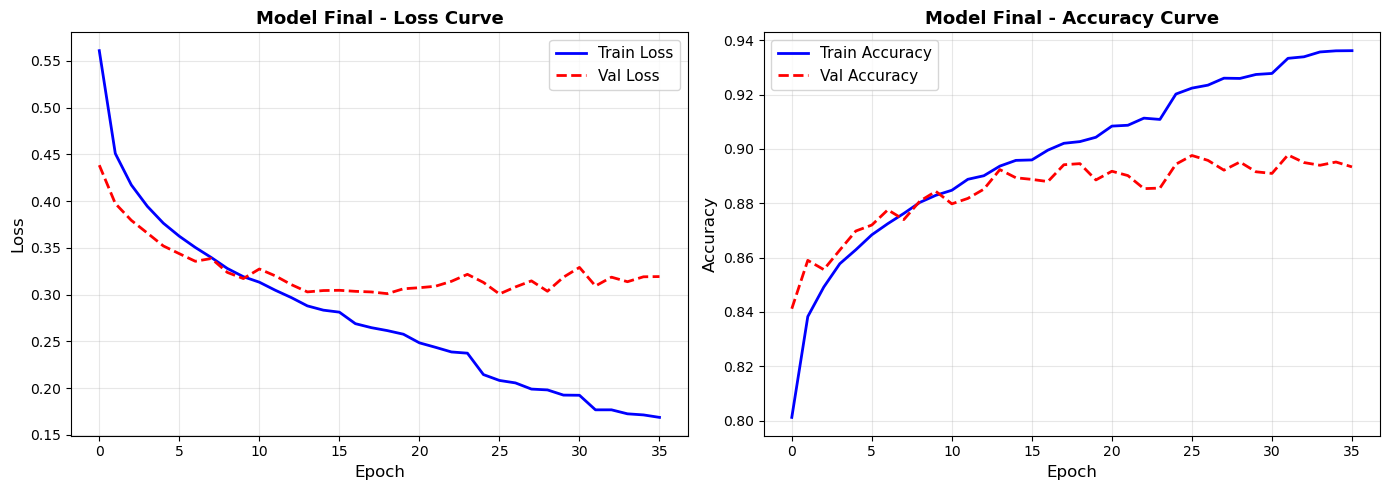

In [45]:
# Visualisasi training history model final
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axes[0].plot(history_final.history['loss'], label='Train Loss', linewidth=2, color='blue')
axes[0].plot(history_final.history['val_loss'], label='Val Loss', linewidth=2, linestyle='--', color='red')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model Final - Loss Curve', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(history_final.history['accuracy'], label='Train Accuracy', linewidth=2, color='blue')
axes[1].plot(history_final.history['val_accuracy'], label='Val Accuracy', linewidth=2, linestyle='--', color='red')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model Final - Accuracy Curve', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [46]:
# Summary semua eksperimen
print("="*80)
print("📊 RINGKASAN SEMUA EKSPERIMEN - BAB 11: TRAINING DEEP NEURAL NETWORKS")
print("="*80)

print("\n1️⃣  FUNGSI AKTIVASI:")
print(f"    • ELU:        {test_acc_elu:.4f}")
print(f"    • ReLU:       {test_acc_relu:.4f}")
print(f"    • Leaky ReLU: {test_acc_leaky:.4f}")
print("    → Winner: ELU (smooth gradients, mengatasi dying ReLU)")

print("\n2️⃣  BATCH NORMALIZATION:")
print(f"    • Tanpa BN:  {test_acc_no_bn:.4f}")
print(f"    • Dengan BN: {test_acc_with_bn:.4f}")
print(f"    → Peningkatan: {(test_acc_with_bn - test_acc_no_bn)*100:.2f}% (lebih stabil & cepat konvergen)")

print("\n3️⃣  OPTIMIZER:")
for name, acc in test_accuracies.items():
    print(f"    • {name:10s}: {acc:.4f}")
print("    → Winner: Adam/Nadam (adaptive learning rate, konvergensi tercepat)")

print("\n4️⃣  LEARNING RATE SCHEDULING:")
print(f"    • Dengan ReduceLROnPlateau: {test_acc_lr:.4f}")
print("    → LR turun otomatis saat stuck, membantu fine-tuning")

print("\n5️⃣  REGULARISASI (Mengatasi Overfitting):")
for name, acc in test_accs_reg.items():
    print(f"    • {name:25s}: {acc:.4f}")
print("    → Kombinasi Dropout + L2 memberikan generalisasi terbaik")

print("\n6️⃣  MODEL FINAL (Best Practices):")
print(f"    • Test Accuracy: {test_acc_final:.4f}")
print("    • Konfigurasi: ELU + Batch Norm + Dropout + Nadam + LR Scheduling")
print("    • Early Stopping digunakan untuk menghindari overtraining")

print("\n" + "="*80)
print("🎯 KESIMPULAN:")
print("="*80)
print("• He Initialization + ELU/SELU untuk aktivasi")
print("• Batch Normalization untuk stabilitas dan kecepatan")
print("• Adam/Nadam optimizer untuk adaptive learning")
print("• Dropout + L2 untuk mencegah overfitting")
print("• Learning Rate Scheduling untuk fine-tuning optimal")
print("• Early Stopping untuk efisiensi training")
print("="*80)

📊 RINGKASAN SEMUA EKSPERIMEN - BAB 11: TRAINING DEEP NEURAL NETWORKS

1️⃣  FUNGSI AKTIVASI:
    • ELU:        0.8776
    • ReLU:       0.8826
    • Leaky ReLU: 0.8689
    → Winner: ELU (smooth gradients, mengatasi dying ReLU)

2️⃣  BATCH NORMALIZATION:
    • Tanpa BN:  0.8828
    • Dengan BN: 0.8550
    → Peningkatan: -2.78% (lebih stabil & cepat konvergen)

3️⃣  OPTIMIZER:
    • SGD       : 0.8711
    • Momentum  : 0.8723
    • RMSprop   : 0.8517
    • Adam      : 0.8738
    • Nadam     : 0.8806
    → Winner: Adam/Nadam (adaptive learning rate, konvergensi tercepat)

4️⃣  LEARNING RATE SCHEDULING:
    • Dengan ReduceLROnPlateau: 0.8826
    → LR turun otomatis saat stuck, membantu fine-tuning

5️⃣  REGULARISASI (Mengatasi Overfitting):
    • Tanpa Regularisasi       : 0.8772
    • Dengan Dropout           : 0.8786
    • Dengan L2                : 0.8254
    • Dropout + L2             : 0.8070
    → Kombinasi Dropout + L2 memberikan generalisasi terbaik

6️⃣  MODEL FINAL (Best Practices

## Evaluasi Final: Model Terbaik

Berdasarkan semua eksperimen di atas, mari kita buat model final dengan konfigurasi terbaik dan evaluasi secara menyeluruh.